In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, binom
from numpy import random
import mplhep as hep
import pandas as pd
import uproot3
import timeit
import seaborn as sns
from tqdm import tqdm
import math

In [26]:
def GenerateDataset(Nevents, mu, fSD=0.3, pV_ND = 0.9, pV_D = 0.6, p_pps = 0.05):
    start = timeit.default_timer()
    nVtx=np.zeros(Nevents, dtype=np.uint32)
    nProtons=np.zeros(Nevents, dtype=np.uint32)
    Nint = random.poisson(mu,Nevents);

    for i in tqdm(range(Nevents)): #loop over all events
        random_numbers = random.rand(Nint[i]*4)
        for j in range(Nint[i]): # loop over all interactions in event
            #check collision type:
            if random_numbers[4*j+0] > fSD:
                #this is a non diffractive event
                if random_numbers[4*j+1] < pV_ND: 
                    nVtx[i]+=1
            else:
                #this is a diffractive event
                if random_numbers[4*j+2] < pV_D: 
                    nVtx[i]+=1
                if random_numbers[4*j+3] < p_pps: 
                    nProtons[i]+=1
        if nProtons[i]>1: nProtons[i]=0
    stop = timeit.default_timer()
    print('probability for PU proton in collision',fSD*p_pps)
    print('probability to form a vertex in collision',fSD*pV_D+(1-fSD)*pV_ND)
    print('Time: %2.2fsec for %d events'%(stop - start,Nevents))
    d = {'nvtx': nVtx, 'nprotons': nProtons, 'nint': Nint}
    return pd.DataFrame(data=d)

In [3]:
def GenerateDataset2(Nevents, mu, beta=0.015, pv = 0.75):
    start = timeit.default_timer()
    nVtx=np.zeros(Nevents, dtype=np.uint32)
    nProtons=np.zeros(Nevents, dtype=np.uint32)
    Nint = random.poisson(mu,Nevents);

    for i in tqdm(range(Nevents)):
        nVtx[i]=np.sum(random.rand(Nint[i])<pv)
        nProtons[i]=np.sum(random.rand(Nint[i])<beta)
        if nProtons[i]>1: nProtons[i]=0
            
    stop = timeit.default_timer()
    print('probability for PU proton in collision',beta)
    print('probability to form a vertex in collision',pv)
    print('Time: %2.2fsec for %d events'%(stop - start,Nevents))
    d = {'nvtx': nVtx, 'nprotons': nProtons, 'nint': Nint}
    return pd.DataFrame(data=d)

# Generation of toys

In [91]:
Nevents = 10000000 # number of evnets
mu = 3 #number of additional interactions

#probability of ND event
p_ND=0.7
#probability of vertex in Diffractive and ND events
pV_D = 0.6
pV_ND = 0.9
#probability of PU proton in PPS acceptance from Diffractive event
p_pps = 0.05
print('probability for PU proton in collision',(1-p_ND)*p_pps)

#generation of events:
start = timeit.default_timer()
nVtx=np.ones(Nevents, dtype=np.uint32)
nProtons=np.zeros(Nevents, dtype=np.uint32)
Nint = random.poisson(mu,Nevents);

for i, n in enumerate(Nint):
    random_numbers = random.rand(n*4)
    for j in range(n):
        #collision type:
        if random_numbers[4*j+0] < p_ND:
            #non diffractive event
            if random_numbers[4*j+1] < pV_ND: 
                nVtx[i]+=1
        else:
            #diffractive event
            if random_numbers[4*j+2] < pV_D: 
                nVtx[i]+=1
            if random_numbers[4*j+3] < p_pps: 
                nProtons[i]+=1
    if nProtons[i]>1: nProtons[i]=0
stop = timeit.default_timer()
print('Time: %2.2fsec for %d events'%(stop - start,Nevents))

#create dataframe:
d = {'nvtx': nVtx, 'nprotons': nProtons, 'nint': Nint+1}
df = pd.DataFrame(data=d)

Time: 103.86sec for 10000000 events


# Generate from function

In [27]:
N = 1000000; mu = 3; fSD=0.25; pV_ND = 8/9; pV_D = 1/3;  p_pps = 0.06;
df1=GenerateDataset(N, mu=mu, fSD = fSD, pV_D = pV_D, pV_ND = pV_ND, p_pps = p_pps)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:41<00:00, 24375.07it/s]

probability for PU proton in collision 0.015
probability to form a vertex in collision 0.75
Time: 41.17sec for 1000000 events


In [5]:
N = 1000000; mu = 3; beta=0.015; pv = 0.75
df=GenerateDataset2(N, mu=mu,beta=beta, pv = pv)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:53<00:00, 18614.65it/s]

probability for PU proton in collision 0.015
probability to form a vertex in collision 0.75
Time: 53.85sec for 1000000 events


In [228]:

print(df[df['nvtx']==6]['nprotons'].mean(),df1[df1['nint']==6]['nprotons'].mean())

0.09289899943563318 0.08292473682015597


In [229]:
print(df['nprotons'].mean(),df1['nprotons'].mean())

0.0429375 0.0430674


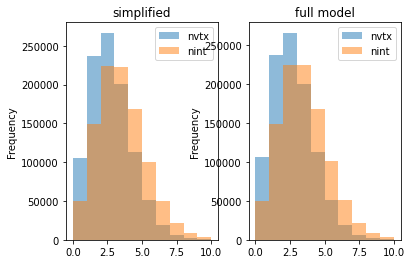

In [6]:
f, ax = plt.subplots(1,2)
df[['nvtx', 'nint']].plot.hist(bins=np.linspace(0,10,11), alpha=0.5, ax=ax[0], title='simplified');
df1[['nvtx', 'nint']].plot.hist(bins=np.linspace(0,10,11), alpha=0.5, ax=ax[1],title='full model');

### Fit of the statistical model


In [13]:
#anal expression of the model will go here
def Pn(_n, pvd, pvnd, beta_D, mu, fd):
    y=np.zeros(len(_n))
    pv=fd*pvd+(1-fd)*pvnd
    beta=beta_D*fd
    #print('beta=%f, pv=%f'%(beta,pv))
    p0d = (1-pvd)
    p0nd = (1-pvnd)
    for i, n in enumerate(_n):
        if n==0: y[i] = mu*beta*p0d*np.exp(-mu*p0d*beta)
        elif n==1: y[i] = mu*beta*(pvd + mu*p0d*(fd-beta+(1-fd)*pvnd))/(pv)*np.exp(-mu*p0d*beta)
        elif n==2: y[i] = beta*(p0nd*pvd+p0d*pvnd)/pv/p0nd*np.exp(-mu*p0d*beta)
        else: y[i] = 0
    return y

In [285]:
#make profile
_df=df1
binned = _df[_df['nvtx']<11].groupby('nvtx')
result = binned['nprotons'].agg(['mean','sem'])
result['x']=np.linspace(0,max(binned.groups.keys()),max(binned.groups.keys())+1)
result['xerr']=0.5

In [302]:
def Prob(n,pvd,pvnd,beta_D,fd,mu):
    # pribability to measyre 1 proton given measured n vertices
    
    pv = fd*pvd + (1-fd)*pvnd
    beta = beta_D*fd
    fb = pvd / pv * beta
    alpha = mu*(1-pvd)*beta
    
    return fb*np.power(1-fb,n-1)*np.exp(-alpha)*(n+alpha*(1-fb)/fb)

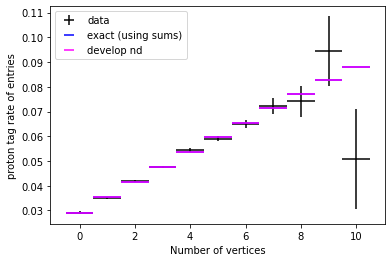

In [303]:
#plot ptoron tag rate vs number of vertices and the function
f, ax = plt.subplots()
result.plot(x='x',y='mean',xerr='xerr',yerr='sem',linestyle='none',capsize=0,color='black',label='data',ax=ax)
ax.set(xlabel='Number of vertices', ylabel='proton tag rate of entries')
#beta = p_pps*(1-p_ND); pv =(p_ND*pV_ND+(1-p_ND)*pV_D); p0 = mu*(1 - pv)
beta = 0.015; p0 = 0.75
x = np.linspace(0,10,11); 
#yn = beta*np.power(1-beta,x-1)*np.exp(-beta*p0)*(x+(1-beta)*p0)
ynf = [P1(int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu) for _n in x]
ynnd = [Prob(int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu) for _n in x]

#yk = x*beta*np.power(1-beta,x-1)
plt.errorbar(x=x,y=ynf,xerr=0.5,label='exact (using sums)',linestyle='none',color='blue')
plt.errorbar(x=x,y=ynnd,xerr=0.5,label='develop nd ',linestyle='none',color='magenta')
ax.legend(loc=2)
plt.show()


In [ ]:
N = 10000000; mu = 30; p_ND=0.75; pV_ND = 8/9; pV_D = 1/3;  p_pps = 0.06;

In [281]:
print('probability for PU proton in collision',(1-p_ND)*p_pps)
print('probability to form a vertex in collision',p_ND*pV_ND+(1-p_ND)*pV_D)
print('fitted fbeta = ',(1-p_ND)*p_pps*pV_D/(p_ND*pV_ND+(1-p_ND)*pV_D))
print('fitted pvd/pv = ',pV_D/(p_ND*pV_ND+(1-p_ND)*pV_D))
print('alpha = ',mu*(1-pV_D))


probability for PU proton in collision 0.015
probability to form a vertex in collision 0.75
fitted fbeta =  0.006666666666666665
fitted pvd/pv =  0.4444444444444444
alpha =  20.000000000000004


### save as a root file

In [271]:
N = 10000000; mu = 30; p_ND=0.75; pV_ND = 8/9; pV_D = 1/3;  p_pps = 0.06;
df1=GenerateDataset(N ,mu = mu, p_ND=p_ND, pV_D = pV_D, pV_ND = pV_ND, p_pps = p_pps)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [11:23<00:00, 14624.94it/s]

probability for PU proton in collision 0.015
probability to form a vertex in collision 0.75
Time: 684.40sec for 10000000 events


In [4]:
#save as a root file
df=df1
with uproot3.recreate("toys.root") as f:
    f["Events"] = uproot3.newtree({"nvtx": "int32", "nProtons": "int32", "nint": "int32"})
    f["Events"].extend({"nvtx": df['nvtx'], "nProtons": df['nprotons'], "nint": df['nint']})

### Stat model

Probability to measure a single proton vs number of additional vertices is given by:
$$ P(1|n_{vtx}) = f(n_{vtx}, f_{D}, \beta_{D}, p_{pv}^{D}, p_{pv}^{ND}) $$

Where $f_{D}$ is the fraction of diffractive interactions with $\beta_{D}$ the probability to observed a tagged proton in a diffractive interaction, $p_{pv}^{D}$ and $p_{pv}^{ND}$ are the probability to recontruct a vertex from diffractive or non-diffracgive interaction respectively.  

To derive the formula we define a set of orthogonal event selections $(k,k_d)$, where $k$ is the number of additional interactions where $k_d$ and $k-k_d$ are diffractive and non-diffractive respectively. Then the probability can be rewriten as:
$$ P(1|n_{vtx}) = P(1 \text{ and } n_{vtx} ) / P(n_{vtx}) = \Sigma_{k,k_d} P(1 \text{ and } n_{vtx} | k,k_d)  P(k,k_d) / P(n_{vtx}) $$

Since number of vertices and number of protons depends only on the type of the interactions, then this breakdown insure unconditionality: 
$$ P(1 \text{ and } n_{vtx} | k,k_d) = P(1| k,k_d) \cdot P( n_{vtx} | k,k_d) $$,

then the probabilty will be of a form of:

$$ P(1|n_{vtx}) = \Sigma_{k,k_d} \left( P(1| k,k_d) \cdot P( n_{vtx} | k,k_d) \right) P(k,k_d) / P(n_{vtx}) $$


Let's derive the two expressions, the probability to observe event with $p$ protons:

$$ P( p | k,k_d) = \binom{k_d}{p} \cdot \beta_D^{p}\left( 1 - \beta_D\right)^{k_d-p} $$  

For $p\leq k_d$, and in particular for $p=1$:

$$ P( 1 | k,k_d) = k_d\beta_D\left( 1 - \beta_D\right)^{k_d-1}$$  

Probability for $k$ interactions with $k_d$ diffractive:

$$P(k,k_d) = \frac{\mu^k e^{-\mu}}{k!} \cdot \binom{k}{k_d} \cdot f_D ^ {k_d} \left( 1- f_D \right) ^ {k - k_d}$$


Probability for number of vertices:
$$ P(n_{vtx}) = \frac{\left(p_V\mu\right)^{n_{vtx}} e^{-p_V\mu}}{n_{vtx}!} $$ 

When $p_V^{ND} = p_V^{D} = p_V $ we obtain:

$$ P(1|n_{vtx}) = \beta \left( 1- \beta \right)^n e^{-\beta\mu(1-p_V)}\left( \frac{n}{1-\beta} +  \mu(1-p_V) \right) $$ 

The general soluation is:

$$ P(1|n_{vtx}) = \beta \left( 1- \beta f_{pvd}\right)^n e^{-\beta\mu(1-p_V)}\left( \frac{n\times f_{pvd}}{1-\beta f_{pvd}} +  \mu(1-p_V) \right) $$ 

where $f_{pvd} = p_V^D/p_V$

In [244]:
def P_proton(p,kd,beta_D):
    # P( p | k, kd ) - probability to measure p protons given kd diffractive interactions
    return math.comb(kd, p)*np.power(beta_D,p)*np.power(1-beta_D,kd-p)

def P_n_nd(n,k,kd,pvd,pvnd,nd):
    # P( n | k, kd , nd ) - probability to measure n vertices given (k,kd) interactions and nd diff. vertices
    if nd < np.max([0,n+kd-k]): return 0
    if nd > np.min([n,kd+1]): return 0
    p1=math.comb(kd, nd)*np.power(pvd,nd)*np.power(1-pvd,kd-nd)
    p2=math.comb(k-kd, n-nd)*np.power(pvnd,n-nd)*np.power(1-pvnd,k-kd-n+nd)        
    return p1*p2

def P_n(n,k,kd,pvd,pvnd):
    # P( n | k, kd ) - probability to measure n vertices given (k,kd) interactions
    out=0
    #print('calculate P(n|k,kd) limit nd in range',np.max([0,n+kd-k]),np.min([n,kd+1])+1)
    for nd in range(np.max([0,n+kd-k]),np.min([n,kd+1])+1):
        out=out+P_n_nd(n,k,kd,pvd,pvnd,nd)
    return out

def Pk(k,kd,mu,fd):
    # P ( k, kd ) probability to have k interactions with kd diffractive ones
    return np.power(mu,k)*np.exp(-mu)/math.factorial(k)*math.comb(k, kd)*np.power(fd,kd)*np.power(1-fd,k-kd)

def P(n,pvd,pvnd,fd,mu):
    # probability to measure n vertiecs
    pv = fd*pvd + (1-fd)*pvnd
    nv = mu*pv
    #print('calculate vertex probability with <n>=',nv)
    return np.power(nv,n)*np.exp(-nv)/math.factorial(n)

def P1(n,pvd,pvnd,beta_D,fd,mu):
    # pribability to measyre 1 proton given measured n vertices
    out= 0; #1/P(n,pvd,pvnd,fd,mu)
    for k in range(n,80+1):
        for kd in range(0,k+1):
            out=out+P_proton(1,kd,beta_D)*P_n(n,k,kd,pvd,pvnd)*Pk(k,kd,mu,fd)
    return out/P(n,pvd,pvnd,fd,mu)

def Prob(p, n,pvd,pvnd,beta_D,fd,mu):
    # pribability to measyre 1 proton given measured n vertices
    out= 0; #1/P(n,pvd,pvnd,fd,mu)
    for k in range(n,80+1):
        for kd in range(0,k+1):
            for nd in range(np.max([0,n+kd-k]),np.min([n,kd+1])+1):
                out=out+P_proton(p,kd,beta_D)*P_n_nd(n,k,kd,pvd,pvnd,nd)*Pk(k,kd,mu,fd)
    return out/P(n,pvd,pvnd,fd,mu)




In [ ]:
 mu = 3; p_ND=0.75; pV_ND = 8/9; pV_D = 1/3;  p_pps = 0.06;

In [ ]:
# beta_D=p_pps,  pvd=pV_D, pvnd=pV_ND, fd=(1-p_ND), mu=mu

In [ ]:
n = range(10)
anal=Pn(n, pvd=pV_D, pvnd=pV_ND, beta_D=p_pps, mu=mu, fd=(1-p_ND))
for i, _n in enumerate(n):
    function=P1(_n,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu)
    code=0
    for k in range(_n,30):
        for kd in range(0,k+1):
            code=code+P_proton(1,kd,beta_D=p_pps)*P_n(_n,k,kd,pvd=pV_D, pvnd=pV_ND)*Pk(k,kd,mu=mu,fd=(1-p_ND))
    code/=P(_n,pvd=pV_D, pvnd=pV_ND, fd=(1-p_ND), mu=mu)
    print('n=%d anal = %f, code = %f, function = %f, sim = %f'%(_n,anal[i],code,function, result['mean'].values[i]))

### Solving for different $n_d$



In [58]:
def P1_break_nd(n,pvd,pvnd,beta_D,fd,mu, nd):
    # pribability to measyre 1 proton given measured n vertices
    out= 0;
    for k in range(n,10+1):
        for kd in range(1,k+1):
#            for nd in range(np.max([0,n+kd-k]),np.min([n,kd+1])+1):
            out=out+P_proton(1,kd,beta_D)*P_n_nd(n,k,kd,pvd,pvnd,nd)*Pk(k,kd,mu,fd)
    return out/P(n,pvd,pvnd,fd,mu)

In [257]:
def Prob(p, n,pvd,pvnd,beta_D,fd,mu):
    # pribability to measyre 1 proton given measured n vertices
    
    pv = fd*pvd + (1-fd)*pvnd
    beta = beta_D*fd
    fvd = pvd / pv
    
    return beta*np.power(1-beta*fvd,n)*np.exp(-mu*beta*(1-pvd))*(n*fvd/(1-beta*fvd)+(1-pvd)*mu)


for _n in range(20):
    real=P1(int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu)
    deval=Prob(1, int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu)
    print('n=%d, real = %f, deval = %f'%(_n,real,deval))



n=0, real = 0.029113, deval = 0.029113
n=1, real = 0.035389, deval = 0.035389
n=2, real = 0.041579, deval = 0.041579
n=3, real = 0.047686, deval = 0.047686
n=4, real = 0.053709, deval = 0.053709
n=5, real = 0.059650, deval = 0.059650
n=6, real = 0.065509, deval = 0.065509
n=7, real = 0.071287, deval = 0.071287
n=8, real = 0.076986, deval = 0.076986
n=9, real = 0.082605, deval = 0.082605
n=10, real = 0.088146, deval = 0.088146
n=11, real = 0.093610, deval = 0.093610
n=12, real = 0.098996, deval = 0.098996
n=13, real = 0.104303, deval = 0.104307
n=14, real = 0.109504, deval = 0.109542
n=15, real = 0.114414, deval = 0.114703
n=16, real = 0.117977, deval = 0.119791
n=17, real = 0.115749, deval = 0.124805
n=18, real = 0.095645, deval = 0.129747
n=19, real = 0.045634, deval = 0.134618


In [146]:
math.comb(0, 2)

0

In [205]:
def Prob2(p, n,pvd,pvnd,beta_D,fd,mu):
    # pribability to measyre 1 proton given measured n vertices
    
    pv = fd*pvd + (1-fd)*pvnd
    nv = mu*pv
    beta = beta_D*fd
    
    a=(1-beta_D)*fd*(1-pvd)
    b=(1-fd)*(1-pvnd)

    out_k= 0; #1/P(n,pvd,pvnd,fd,mu)
    p0=np.exp(nv)/(np.power(nv,n)/math.factorial(n))
    p0*=np.power(beta,p)*np.exp(-mu)
    for k in range(n,80+1):
        out_nd=0
        fac_k=np.power(mu,k)/math.factorial(k)
        for nd in range(0,n+1):
            out_kd=0
            frac_nd=np.power(pvd,nd)*np.power(pvnd,n-nd)*np.power(1-pvd,p-nd)*np.power(1-fd,n-nd)*np.power(a,nd-p)
            frac_nd=frac_nd
            for kd in range(np.max([nd,p]),k-n+nd+1):
                p1=math.comb(kd, p)
                p2_1=math.comb(kd, nd)
                p2_2=math.comb(k-kd, n-nd)
                p3=1*math.comb(k, kd)
                out_kd=out_kd+p1*p2_1*p2_2*p3*np.power(a,kd-nd)*np.power(b,(k-n)-(kd-nd))
            out_nd+=out_kd*frac_nd
        out_k+=(out_nd)*fac_k
    return out_k*p0


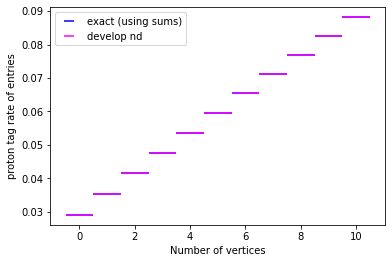

In [147]:
#plot ptoron tag rate vs number of vertices and the function
f, ax = plt.subplots()
ax.set(xlabel='Number of vertices', ylabel='proton tag rate of entries')
x = np.linspace(0,10,11); 

ynf = [P1(int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu) for _n in x]
ynnd = [Prob(1, int(_n),pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu) for _n in x]

#yk = x*beta*np.power(1-beta,x-1)
plt.errorbar(x=x,y=ynf,xerr=0.5,label='exact (using sums)',linestyle='none',color='blue')
plt.errorbar(x=x,y=ynnd,xerr=0.5,label='develop nd ',linestyle='none',color='magenta')
ax.legend(loc=2)
plt.show()


In [107]:
def P1_break_nd_2(n,pvd,pvnd,beta_D,fd,mu, nd):
    # probability to measyre 1 proton given measured n vertices and nd diffractive
    beta=beta_D*fd
    pv = fd*pvd + (1-fd)*pvnd
    nv = mu*pv
    a=(1-beta_D)*fd*(1-pvd)
    b=(1-fd)*(1-pvnd)
    p0= beta*np.exp(-mu)*np.exp(nv)/np.power(nv,n)/math.factorial(n)
    p0=p0*np.power(pvnd,n-nd)/np.power(1-pvnd,n-nd)*np.power(pvd,nd)/np.power(1-pvd,nd-1)
    p0=p0*math.comb(n, nd)/math.factorial(n)*np.power(a,nd-1)*np.power(b,n-nd)
    out_k= 0;
    for k in range(n,50+1):
        out_kd=0
        for kd in range(nd,k+1):
            if nd < np.max([0,n+kd-k]): 
                #print('skip --------------------- kd=%d for k=%d'%(kd,k))
                continue
            if nd > np.min([n,kd+1]): 
                #print('skip --------------------- kd=%d for k=%d'%(kd,k))
                continue
            #out_kd+=math.comb(k-1, kd-1)*math.comb(kd, nd)*math.comb(k-kd, n-nd)*np.power(a,kd-1)*np.power(b,k-kd)
            out_kd+=math.comb(k-n, kd-nd)*kd*np.power(a,kd-nd)*np.power(b,k-n-kd+nd)
            #math.factorial(k-1)/math.factorial(k-n)*math.comb(n, nd)*math.comb(k-n, kd-nd)
        out_k+=k*np.power(mu,k)/k/math.factorial(k-n)*out_kd
    return out_k*p0

def P1_break_nd_3(n,pvd,pvnd,beta_D,fd,mu, nd):
    # pribability to measyre 1 proton given measured n vertices and nd diffractive
    beta=beta_D*fd
    pv = fd*pvd + (1-fd)*pvnd
    nv = mu*pv
    out=0
    p0= beta*np.exp(-mu)/pv/np.exp(-nv);
    for k in range(n,50+1):
        p1=np.power(mu,k-1)/math.factorial(k-1)
        for kd in range(1,k+1):
            out+=p0*p1*np.power(fd*(1-beta_D),kd-1)*np.power(1-fd,k-kd)*P_n_nd(n,k,kd,pvd,pvnd,nd)
    return out

print(P1_break_nd(3,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=2))
print(P1_break_nd_2(3,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=2))
print(P1_break_nd_3(3,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=2))

0.004450726794652695
0.00012363129985140038
0.0013766643589915788


<ipython-input-107-e7e094f03f26>:49: RuntimeWarning: overflow encountered in int_scalars
  out_k+=k*np.power(mu,k)/k/math.factorial(k-n)*out_kd


In [46]:
print('P(1, n=0):')
summ=0
for nd in range(1):
    print('nd = ',nd,' sum+=',P1_break_nd(0,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=nd))
    summ+=P1_break_nd(0,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=nd)
print(' total = ',summ)


print('P(1, n=1):')
summ=0
for nd in range(2):
    print('nd = ',nd,' sum+=',P1_break_nd(1,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=nd))
    summ+=P1_break_nd(1,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps,fd=(1-p_ND),mu=mu, nd=nd)
print(' total = ',summ)

print(calcpart(1,pvd=pV_D, pvnd=pV_ND, beta_D=p_pps, mu=mu, fd=(1-p_ND)))

P(1, n=0):
nd =  0  sum+= 0.029113366006455255
 total =  0.029113366006455255
P(1, n=1):
nd =  0  sum+= 0.02587854756129356
nd =  1  sum+= 0.009510366228775378
 total =  0.035388913790068935
0.007483213336474051


In [45]:
def calcpart(_n, pvd, pvnd, beta_D, mu, fd):
    pv=fd*pvd+(1-fd)*pvnd
    beta=beta_D*fd
    p0d = (1-pvd)
    p0nd = (1-pvnd)
    #y = mu*beta*p0d*np.exp(-mu*p0d*beta)
    #y = mu*beta*p0d*(pvnd*(1-fd))/pv*np.exp(-mu*p0d*beta)
    y = beta*pvd/pv*(1+mu*(fd-beta)*p0d*pvd)*np.exp(-mu*p0d*beta)
    return y


In [148]:
out=0
for k in range(0,20+1):
    for kd in range(0,k+1):
        out+=P_n(0,k,kd,pvd=pV_D, pvnd=pV_ND)*Pk(k,kd,mu=mu,fd=(1-p_ND))
print(out)
print(P_n(0,1,0,pvd=pV_D, pvnd=pV_ND))

0.10539922456186433
0.11111111111111116


In [183]:
def Ptest(n,pvd,pvnd,fd,mu):
    out=0
    for k in range(0,20):
        for kd in range(0,k+1):
            out=out+P_n(n,k,kd,pvd,pvnd)*Pk(k,kd,mu,fd)
    return out

sum1=0
sum2=0
for n in range(20):
    sum1+=P(n,pvd=pV_D, pvnd=pV_ND,fd=(1-p_ND),mu=mu)
    sum2+=Ptest(n,pvd=pV_D, pvnd=pV_ND,fd=(1-p_ND),mu=mu)
    print(P(n,pvd=pV_D, pvnd=pV_ND,fd=(1-p_ND),mu=mu),Ptest(n,pvd=pV_D, pvnd=pV_ND,fd=(1-p_ND),mu=mu))
print('------------------------------------')    
print('sum',sum1,sum2)

0.10539922456186433 0.10539922456186433
0.23714825526419475 0.23714825526419459
0.2667917871722191 0.2667917871722191
0.20009384037916433 0.2000938403791643
0.11255278521327994 0.1125527852132799
0.05064875334597597 0.05064875334597564
0.01899328250474099 0.018993282504739063
0.0061049836622381745 0.0061049836622265536
0.0017170266550044868 0.0017170266549475825
0.0004292566637511217 0.0004292566635223521
9.658274934400237e-05 9.658274858453731e-05
1.975556236581867e-05 1.975556027958648e-05
3.7041679435909998e-06 3.7041632079265707e-06
6.411059902369038e-07 6.410971499948687e-07
1.0303489128807384e-07 1.0302143962317943e-07
1.5455233693211076e-08 1.5438778849424702e-08
2.1733922381078075e-09 2.1575435000263906e-09
2.876548550436804e-10 2.7600326864540517e-10
3.595685688046005e-11 2.972342893104364e-11
4.258048841107111e-12 2.0113598524766364e-12
------------------------------------
sum 0.9999999999994639 0.9999999999168554
